# Hybrid Feature Analyses SIM 1 - Detecting Kermit and Waldorf & Statler

This notebook outlines the hybrid approach for the Similarity Modeling 2 project. It focuses on merging features extracted for both visual and audio classification to train a model capable of detecting the presence of Kermit or Waldorf and Statler in individual frames. To achieve this, we leverage the XGBoost algorithm, as introduced in the other files.
Due to computational resource constraints, the large number of features and easier model comparison, we exclusively employ the XGBoost Gradient Boosting algorithm for classification.




## Timesheets
**Oleksandra's timesheet**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>

  </tr>
</thead>
<tbody>
  <tr>
    <td>xx.xx.xx</td>
    <td>done something</td>
    <td>how long</td>
  </tr>
</tbody>
</table>

**Mahmoud's timesheet:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>19.01.2025</td>
    <td>Set up the notebook, merge features, run and evaluate Gradient Boosting, document findings</td>
    <td>3 hrs</td>
  </tr>
</tbody>
</table>



In [13]:
import pandas as pd
import numpy as np
from scripts.nested_cv import partition_feature_df

from scripts.load_data import check_and_load

Video Features

In [19]:
video_features_path = "../model_vars/sim1_video/sim1_video_features.csv"
video_feature_df = pd.read_csv(video_features_path)
video_feature_df = video_feature_df.drop(columns=['Kermit', 'StatlerWaldorf'])
video_feature_df.shape

(115885, 537)

Audio Features

In [21]:
audio_features_path = "../model_vars/sim1_audio/feature_df.csv"
audio_feature_df = pd.read_csv(audio_features_path)
audio_feature_df = audio_feature_df.drop(columns=['Kermit', 'Audio_StatlerWaldorf'])
audio_feature_df.shape

(115885, 31)

In [22]:
merged_feature_df = pd.merge(video_feature_df, audio_feature_df, on=['video_idx', 'frame_idx'], how='inner')
merged_feature_df.shape

(115885, 566)

Load Ground Truth

In [23]:
data_path = "../ground_truth_data"
frames_output_dir = "../ground_truth_data/frames"
audio_output_dir = "../ground_truth_data/audio"
annotations_path = "../ground_truth_data"

muppet_files = {
    "Muppets-02-01-01.avi": "GroundTruth_Muppets-02-01-01.csv",
    "Muppets-02-04-04.avi": "GroundTruth_Muppets-02-04-04.csv",
    "Muppets-03-04-03.avi": "GroundTruth_Muppets-03-04-03.csv",
}

annotations, audio_data, frames = check_and_load(data_path, frames_output_dir, audio_output_dir, annotations_path, muppet_files)

Frames and audio are already extracted.
Loading audio segments...
Loaded 3 audio files.
Loaded audio segments for 3 videos.
Loaded frames for 3 videos.
Number of videos with frames: 3
Video 0 has 38681 frames.
Video 1 has 38706 frames.
Video 2 has 38498 frames.


In [24]:
# Create a mapping from filenames to video indices
video_idx_map = {filename: idx for idx, filename in enumerate(muppet_files.keys())}

# Prepare ground truth data with corrected video_idx
ground_truth_data = []
for video_filename, annotation_df in annotations.items():
    video_idx = video_idx_map[video_filename]  # Map video filename to its index
    for _, row in annotation_df.iterrows():
        ground_truth_data.append({
            'video_idx': video_idx,  # Use mapped video index
            'frame_idx': row['Frame_number'],  
            'Kermit': row['Kermit'],  
            'Audio_StatlerWaldorf': row['Audio_StatlerWaldorf'], 
            'StatlerWaldorf': row['StatlerWaldorf'] 
        })

# Create a DataFrame for ground truth
ground_truth_df = pd.DataFrame(ground_truth_data)
ground_truth_df.shape

(115885, 5)

We will create a combined target variable for Statler & Waldorf - in the case of Kermit we only have one Ground Truth Column.

In [25]:
ground_truth_df['StatlerWaldorf_combi'] = (
    (ground_truth_df['Audio_StatlerWaldorf'] == 1) | 
    (ground_truth_df['StatlerWaldorf'] == 1)
).astype(int)

ground_truth_df = ground_truth_df.drop(columns=['Audio_StatlerWaldorf', 'StatlerWaldorf'])

In [26]:
ground_truth_df.head()

,video_idx,frame_idx,Kermit,StatlerWaldorf_combi
0,0,0,0,0
1,0,1,0,0
2,0,2,0,0
3,0,3,0,0
4,0,4,0,0


Merge the ground truth and the feature dataframe

In [27]:
# Merge features with ground truth
feature_df = pd.merge(merged_feature_df, ground_truth_df, on=['video_idx', 'frame_idx'], how='inner')
feature_df.shape

(115885, 568)

Create Partitions

In [28]:
# split_points = {
#     0: 19716,  # Video 0
#     1: 19719,  # Video 1
#     2: 19432, # Video 2 
# }

# Assuming feature_df is the dataframe containing video_idx and frame_idx columns
grp_by = ['Kermit', 'StatlerWaldorf_combi']
feature_df, split_overview = partition_feature_df(feature_df, grp_by = grp_by)

feature_df.shape

print(split_overview)

feature_df['fold'].unique() # ACHTUNG manche fehlen in den Splits!

   video_idx fold  Kermit  StatlerWaldorf_combi
0          0  0-A    2916                  1336
1          0  0-B    2533                   463
2          1  1-A    3925                   665
3          1  1-B    8327                   393
4          2  2-A    5231                   322
5          2  2-B   10277                   531


array(['0-A', '0-B', '1-A', '1-B', '2-A', '2-B'], dtype=object)

Check for Inf, NA etc.

In [29]:
# Select only numeric columns
numeric_df = feature_df.select_dtypes(include=[np.number])


print("NaN in any feature:", feature_df.isnull().values.any())
# Check for infinite values in numeric columns
print("Inf in any numeric feature:", np.isinf(numeric_df.values).any())

# Optionally, find rows with infinite values
rows_with_inf = numeric_df[np.isinf(numeric_df).any(axis=1)].index.tolist()
print("Rows with Inf values:", rows_with_inf)

NaN in any feature: False
Inf in any numeric feature: False
Rows with Inf values: []


# Hybrid Classification

In [30]:
from scripts.nested_cv import evaluate_model, nested_cross_validation, ncv_xgb_gpu


In [36]:
train_cols = feature_df.drop(columns=['Unnamed: 0_x', 
'video_idx',
'Unnamed: 0.4',
'frame_idx',
'Unnamed: 0.3',
'Unnamed: 0.2',
'Unnamed: 0.1',
'Unnamed: 0_y',
'fold',
'Kermit',
'StatlerWaldorf_combi']).columns

# Manual check
train_cols.to_series().to_csv('../model_vars/sim1_hybrid/train_cols.csv', index=False, header=False)

## Train-Test-Split Approach

In this analysis, we employ a nested cross-validation approach for our classification models. The nested cross-validation provides robust model evaluation by incorporating two levels of data splitting: an outer loop for testing model generalization and an inner loop for hyperparameter tuning. The outer loop ensures that the performance metrics reflect how well the model generalizes to entirely unseen data, while the inner loop systematically optimizes the model's parameters using the training data.

A traditional random train-test split could lead to data leakage if frames from the same video appear in both the training and testing sets. This overlap could inflate performance metrics by allowing the model to learn video-specific features rather than generalizable patterns. The nested cross-validation mitigates this risk by ensuring that the outer splits isolate data from different videos, providing a more realistic estimate of the model's ability to generalize across unseen scenarios. 

For the creation of the folds, each episode is split at its midway point, specifically at the transition where a segment ends and the screen briefly fades to black before the next segment begins. This results in two distinct folds per episode, ensuring that each fold captures a separate and coherent part of the episode.

## XGBoost

In [37]:
import torch

if torch.cuda.is_available():
    print(f"CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")


CUDA is available. GPU: NVIDIA GeForce RTX 4070 Ti SUPER


### Kermit

In [38]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}


target_col='Kermit'
results_xgb_kermit, summary_xgb_kermit, best_models_xgb_kermit = ncv_xgb_gpu(
    feature_df=feature_df,
    train_cols=train_cols,
    target_col=target_col,
    param_grid=param_grid,
    eval_metric="auc" # we evaluate for AUC here!
)

## Save Vars
import pickle
with open('../model_vars/sim1_hybrid/kermit_xgb_results.pkl', 'wb') as f:
    pickle.dump({
        'results_kermit': results_xgb_kermit,
        'summary_kermit': summary_xgb_kermit,
        'best_model_kermit': best_models_xgb_kermit
    }, f)


# print("Results:", results_xgb_kermit)
# print("Summary:", summary_xgb_kermit)


Outer Fold: 0-A
Outer Fold: 0-B
Outer Fold: 1-A
Outer Fold: 1-B
Outer Fold: 2-A
Outer Fold: 2-B
Model: 6/6
Summary of Metrics Across Folds:
{'accuracy': 0.7403262079445868, 'precision': 0.6548764083180666, 'recall': 0.4235351958995244, 'f1': 0.4665268829168659, 'roc_auc': 0.7877773921979401}


### Waldorf & Statler

In [39]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}


target_col='StatlerWaldorf_combi'
results_xgb_ws, summary_xgb_ws, best_models_xgb_ws = ncv_xgb_gpu(
    feature_df=feature_df,
    train_cols=train_cols,
    target_col=target_col,
    param_grid=param_grid
)

## Save Vars
import pickle
with open('../model_vars/sim1_hybrid/ws_xgb_results.pkl', 'wb') as f:
    pickle.dump({
        'results_ws': results_xgb_ws,
        'summary_ws': summary_xgb_ws,
        'best_model_ws': best_models_xgb_ws
    }, f)


# print("Results:", results_xgb_ws)
# print("Summary:", summary_xgb_ws)


Outer Fold: 0-A
Outer Fold: 0-B
Outer Fold: 1-A
Outer Fold: 1-B
Outer Fold: 2-A
Outer Fold: 2-B
Model: 6/6
Summary of Metrics Across Folds:
{'accuracy': 0.9840657310198568, 'precision': 0.9543005989531217, 'recall': 0.6199553878823593, 'f1': 0.7186132110953044, 'roc_auc': 0.9670137294979182}


## Evaluation

In [40]:
# load if necessary
import pickle
import pandas as pd

# Load Statler results
with open('../model_vars/sim1_hybrid/ws_xgb_results.pkl', 'rb') as f:
    ws_data = pickle.load(f)
    results_xgb_ws = ws_data['results_ws']
    summary_xgb_ws = ws_data['summary_ws']
    best_models_xgb_ws = ws_data['best_model_ws']

# Load Kermit results
with open('../model_vars/sim1_hybrid/kermit_xgb_results.pkl', 'rb') as f:
    kermit_data = pickle.load(f)
    results_xgb_kermit = kermit_data['results_kermit']
    summary_xgb_kermit = kermit_data['summary_kermit']
    best_model_xgb_kermit = kermit_data['best_model_kermit']

### Kermit

In [41]:
results_xgb_kermit

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.880503,0.660183,0.395748,0.494854,0.888339
1,0-B,0.948748,0.798699,0.823924,0.811115,0.982675
2,1-A,0.831229,0.594612,0.477962,0.529944,0.798706
3,1-B,0.633170,0.801061,0.217605,0.342242,0.704241
4,2-A,0.662207,0.403755,0.534506,0.460020,0.688149
5,2-B,0.486101,0.670949,0.091466,0.160986,0.664556


Fold 0-B Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     16432
           1       0.80      0.82      0.81      2533

    accuracy                           0.95     18965
   macro avg       0.89      0.90      0.89     18965
weighted avg       0.95      0.95      0.95     18965



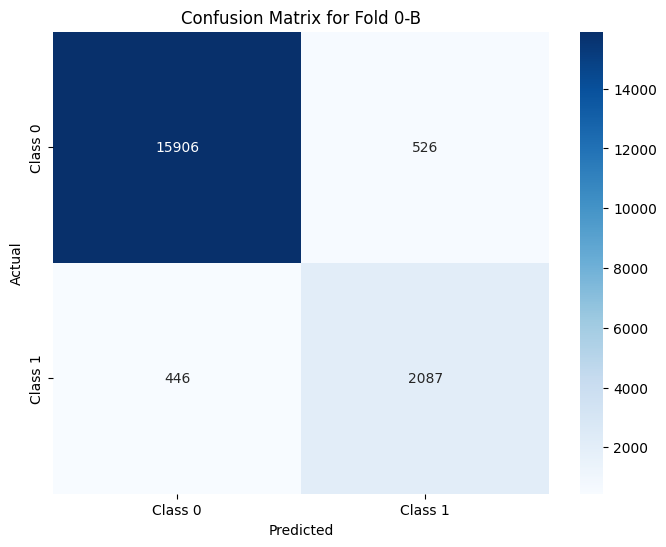

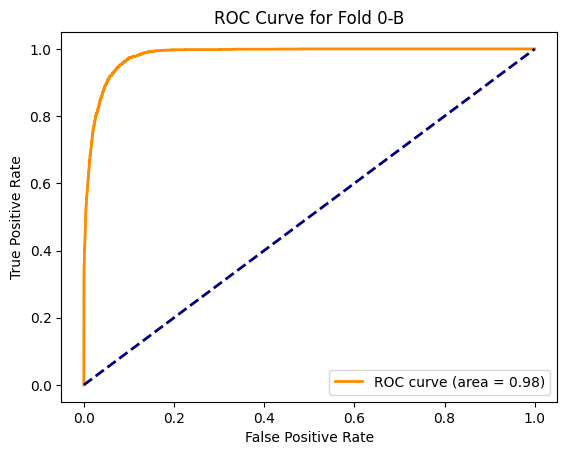

In [42]:
evaluate_model(best_model_xgb_kermit, feature_df, train_cols, 'Kermit', results_xgb_kermit, spec_fold= "best")

Fold 2-B Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.95      0.63      8789
           1       0.67      0.09      0.16     10277

    accuracy                           0.49     19066
   macro avg       0.57      0.52      0.40     19066
weighted avg       0.58      0.49      0.38     19066



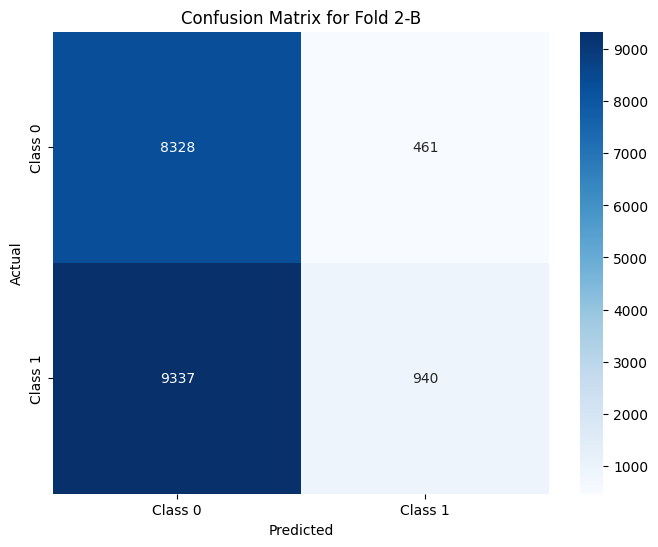

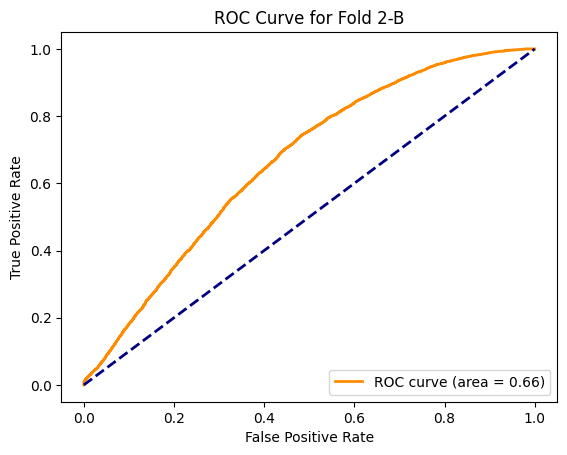

In [43]:
evaluate_model(best_model_xgb_kermit, feature_df, train_cols, 'Kermit', results_xgb_kermit, spec_fold= "worst")

### Waldorf & Statler

In [44]:
results_xgb_ws

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.942230,0.990050,0.148952,0.258946,0.933136
1,0-B,0.991669,0.975078,0.676026,0.798469,0.999426
2,1-A,0.995182,0.956731,0.897744,0.926299,0.994968
3,1-B,0.993469,0.985560,0.694656,0.814925,0.997812
4,2-A,0.992229,0.830116,0.667702,0.740103,0.881332
5,2-B,0.989615,0.988270,0.634652,0.772936,0.995409


Fold 0-B Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18502
           1       0.98      0.68      0.80       463

    accuracy                           0.99     18965
   macro avg       0.98      0.84      0.90     18965
weighted avg       0.99      0.99      0.99     18965



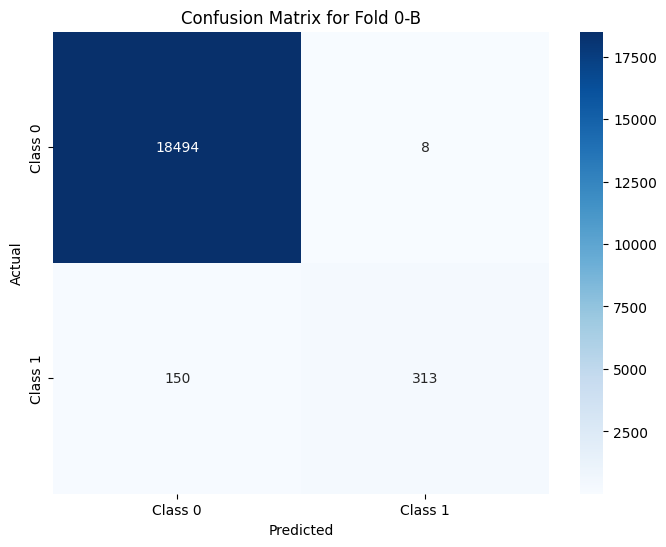

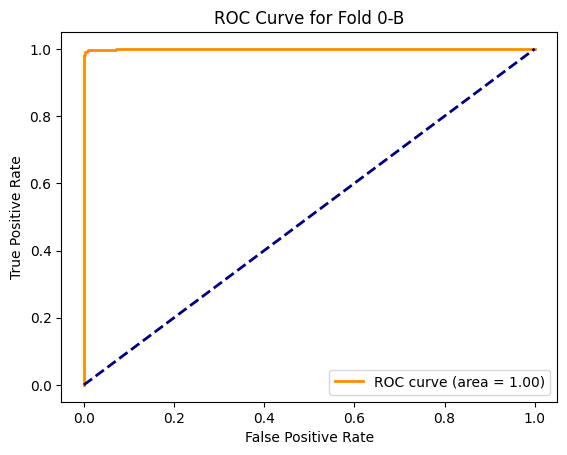

In [45]:
evaluate_model(best_models_xgb_ws, feature_df, train_cols, 'StatlerWaldorf_combi',  results_xgb_ws, spec_fold= "best")

Fold 2-A Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19110
           1       0.83      0.67      0.74       322

    accuracy                           0.99     19432
   macro avg       0.91      0.83      0.87     19432
weighted avg       0.99      0.99      0.99     19432



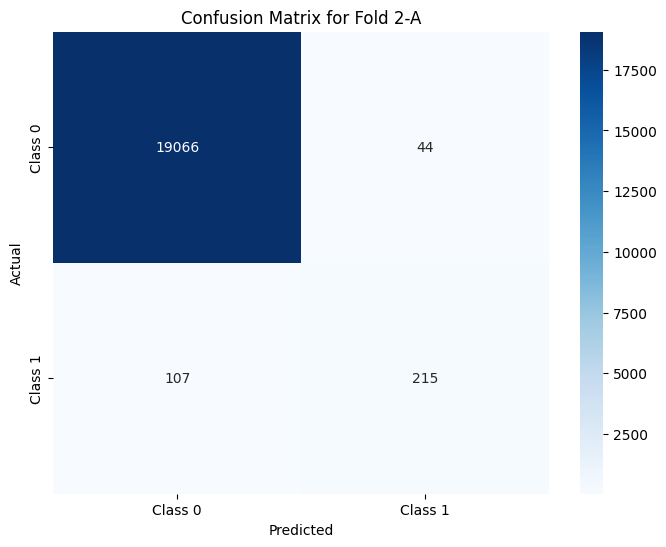

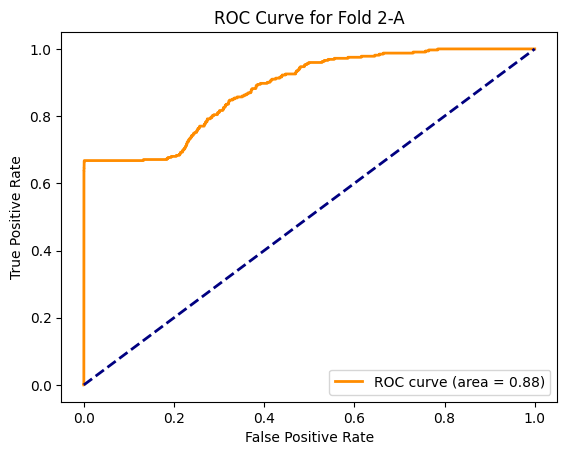

In [46]:
evaluate_model(best_models_xgb_ws, feature_df, train_cols, 'StatlerWaldorf_combi',  results_xgb_ws, spec_fold= "worst")

### Feature Importance

<Figure size 1200x800 with 0 Axes>

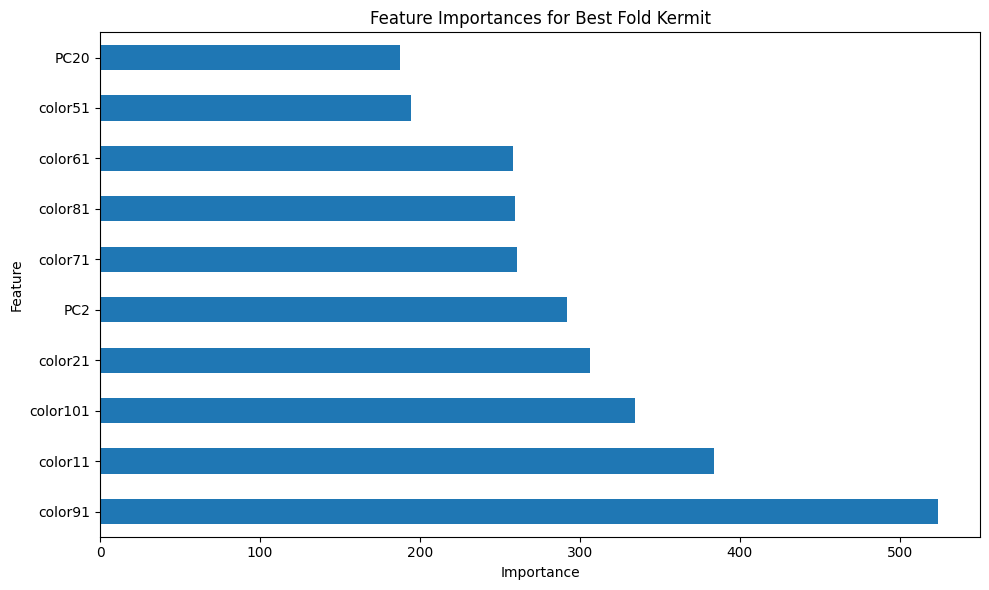

<Figure size 1200x800 with 0 Axes>

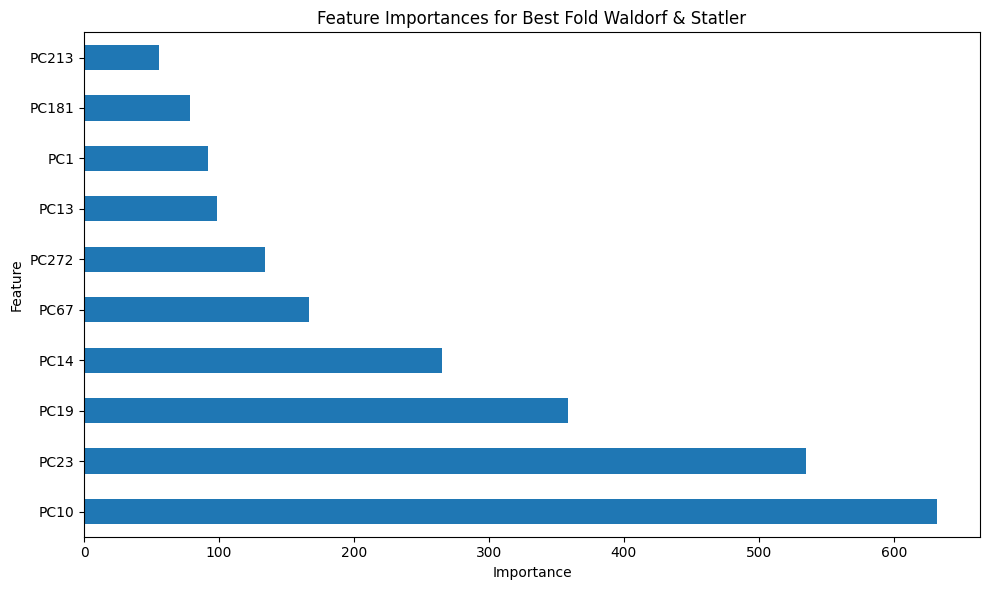

In [47]:
from scripts.nested_cv import plot_feature_importances 

plot_feature_importances(best_model_xgb_kermit, feature_df, train_cols, results_xgb_kermit, name= "Kermit", n= 10)
plot_feature_importances(best_models_xgb_ws, feature_df, train_cols, results_xgb_ws, name= "Waldorf & Statler", n= 10)

## Conclusion

For the detection of Kermit, we observe results similar to those from the visual classification. Fold 0-B remains the best-performing fold, where the model enhanced with audio features identifies the minority class slightly more often. As expected, fold 2-B is the worst-performing fold, showing a decline in performance compared to the purely visual model. However, when compared to the audio-only model, the hybrid approach significantly outperforms it across all folds. 

An analysis of the feature importances for the best-performing fold reveals that the top 10 most influential features are predominantly color features (8 out of 10), which is unsurprising given Kermit's distinctive green color. This highlights the critical role of visual features in identifying Kermit within the dataset.


| Results Kermit - XGBoost      | Accuracy   | Precision  | Recall     | F1        | ROC AUC   |
|---------------------------|------------|------------|------------|-----------|-----------|
| **Audio - Overall**      | 0.7153     | 0.5254     | 0.1874     | 0.2621    | 0.6593    |
| **Visual - Overall**     | 0.7435       | 0.6739        | 0.4086     | 0.4677    | 0.7955      |
| **Hybrid - Overall**      | 0.7403       | 0.6549        | 0.4235     | 0.4665    | 0.7878      |
| **Audio - Best Fold**    | 0.8505     | 0.3755     | 0.1804     | 0.2437    | 0.7478    |
| **Visual - Best Fold**    | 0.9410       | 0.8106        | 0.7284     | 0.7673    | 0.9744      |
| **Hybrid - Best Fold**    | 0.9487       | 0.7987        | 0.8239     | 0.8111    | 0.9827      |


For Waldorf and Statler, we observe results that are nearly identical to those of the visual model. Fold 0-B remains the worst-performing fold, while fold 2-A continues to perform the best. Similarly, the performance of the hybrid model (which is effectively driven by visual features) is significantly better than that of the audio-only model.
This observation is further supported by the feature importance analysis, where the top 10 features are entirely dominated by the principal components of the visual features, emphasizing the critical role of visual data in detecting Waldorf and Statler.

| **Results W & S - XGBoost**  | **Accuracy** | **Precision** | **Recall** | **F1**    | **ROC AUC** |
|-------------------------------|--------------|---------------|------------|-----------|-------------|
| **Audio - Overall**           | 0.7153       | 0.5254        | 0.1874     | 0.2621    | 0.6593      |
| **Visual - Overall**           | 0.9846       | 0.9536        | 0.6485     | 0.7348    | 0.9660      |
| **Hybrid - Overall**          | 0.9841       | 0.9543        | 0.6200     | 0.7186    | 0.9670      |
| **Audio - Best Fold**         | 0.8505       | 0.3755        | 0.1804     | 0.2437    | 0.7478      |
| **Visual - Best Fold**         | 0.9917       | 0.9811        | 0.6739     | 0.7990    | 0.9993      |
| **Hybrid - Best Fold**        | 0.9917       | 0.9751        | 0.6760     | 0.7985    | 0.9994      |
